## Dataset pre-processing

In [1]:
from fastai.collab import *
from fastai.tabular.all import *

In [3]:
path = Path('data')
if not path.exists():
    path.mkdir()
    untar_data('https://github.com/zygmuntz/goodbooks-10k/releases/download/v1.0/goodbooks-10k.zip', dest=path)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls(file_type='text')

(#5) [Path('book_tags.csv'),Path('tags.csv'),Path('books.csv'),Path('ratings.csv'),Path('README.md')]

In [6]:
ratings = pd.read_csv(path/'ratings.csv'); ratings

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


In [6]:
ratings = ratings.iloc[:100000]

In [7]:
ratings.isnull().values.any()

False

In [9]:
books = pd.read_csv(path/'books.csv'); books.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

In [10]:
books.drop(['best_book_id', 'work_id', 'title','books_count', 'language_code', 
            'isbn13', 'isbn','ratings_count', 'work_ratings_count', 
            'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 
            'ratings_4', 'ratings_5','image_url', 'small_image_url'], 
           axis=1, inplace=True)

books.head()

,book_id,goodreads_book_id,authors,original_publication_year,original_title,average_rating
0,1,2767052,Suzanne Collins,2008.0,The Hunger Games,4.34
1,2,3,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,4.44
2,3,41865,Stephenie Meyer,2005.0,Twilight,3.57
3,4,2657,Harper Lee,1960.0,To Kill a Mockingbird,4.25
4,5,4671,F. Scott Fitzgerald,1925.0,The Great Gatsby,3.89


In [11]:
books.isnull().values.any()

True

In [12]:
books.dropna(inplace=True)

In [12]:
ratings = ratings.merge(books)

ratings.head()

,user_id,book_id,rating,goodreads_book_id,authors,original_publication_year,original_title,average_rating
0,1,258,5,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
1,11,258,3,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
2,143,258,4,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
3,242,258,5,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
4,325,258,4,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24


## DataLoaders

In [14]:
dls = CollabDataLoaders.from_df(ratings=ratings, valid_pct=0.2, 
                                user_name='user_id', item_name='original_title',
                                rating_name='rating')

In [15]:
dls.show_batch()

,user_id,original_title,rating
0,950,The Tragedy of Macbeth,2
1,372,"Women's Bodies, Women's Wisdom: Creating Physical and Emotional Health and Healing",4
2,2185,Alias Grace,4
3,2875,The Pelican Brief,4
4,969,The Subtle Knife,4
5,1936,Harry Potter and the Chamber of Secrets,4
6,963,Surfacing,3
7,1069,Rayuela,3
8,885,A Wrinkle in Time,4
9,1753,Life of Pi,4


In [16]:
n_books = len(dls.classes['original_title'])
n_users = len(dls.classes['user_id']);
n_books, n_users

(4879, 1795)

In [17]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

## Model definition && Training

In [19]:
class CollabFiltering(Module):

    def __init__(self, n_users, n_books, n_factors, y_range=(0, 5.5)):
        self.u_weights = Embedding(n_users, n_factors)
        self.u_bias = Embedding(n_users, 1)
        self.i_weights = Embedding(n_books, n_factors)
        self.i_bias = Embedding(n_books, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.u_weights(x[:,0])
        books = self.i_weights(x[:,1])
        res = (users * books).sum(dim=1, keepdims=True)
        res += self.u_bias(x[:,0]) + self.i_bias(x[:,1])
        res = sigmoid_range(res, *self.y_range)
        return res

In [20]:
model = CollabFiltering(n_users, n_books, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=1.5848931980144698e-06)

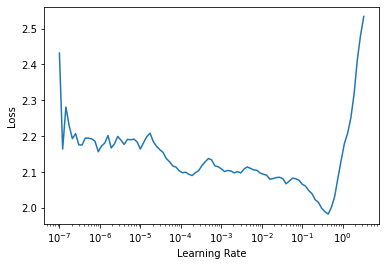

In [21]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(6, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,time
0,1.009270,0.989366,00:04
1,0.949760,0.964218,00:04
2,0.901523,0.909311,00:04
3,0.792446,0.859447,00:04
4,0.661367,0.825357,00:04
5,0.543535,0.822560,00:04


## Interpretation

In [23]:
book_bias = learn.model.i_bias.weight.squeeze()
idxs = book_bias.argsort()[:5]
[dls.classes['original_title'][i] for i in idxs]

['Lost',
 'Eat That Frog!: 21 Great Ways to Stop Procrastinating and Get More Done in Less Time',
 'Four Blondes',
 'A Stranger in the Mirror',
 'The Mermaid Chair']

In [24]:
books.loc[books['original_title']=='A Stranger in the Mirror']

,book_id,goodreads_book_id,authors,original_publication_year,original_title,average_rating
5524,5525,115130,Sidney Sheldon,1976.0,A Stranger in the Mirror,3.61


In [25]:
id = 5525
url = f'https://www.goodreads.com/book/show/{id}'
url

'https://www.goodreads.com/book/show/5525'

In [26]:
idxs = book_bias.argsort(descending=True)[:15]
[dls.classes['original_title'][i] for i in idxs]

['Harry Potter and the Deathly Hallows',
 'The Kite Runner ',
 'To Kill a Mockingbird',
 'A Thousand Splendid Suns',
 'The Giving Tree',
 'Where the Wild Things Are',
 'Le Petit Prince',
 'In Cold Blood',
 "Ender's Game",
 'Harry Potter and the Half-Blood Prince',
 'Un di Velt Hot Geshvign',
 'Dune',
 'Watchmen',
 '窓ぎわのトットちゃん',
 "Cat's Cradle"]

In [27]:
id = int(books.loc[books['original_title']=='窓ぎわのトットちゃん']['goodreads_book_id'].values)
url = f'https://www.goodreads.com/book/show/{id}'
url

'https://www.goodreads.com/book/show/328802'

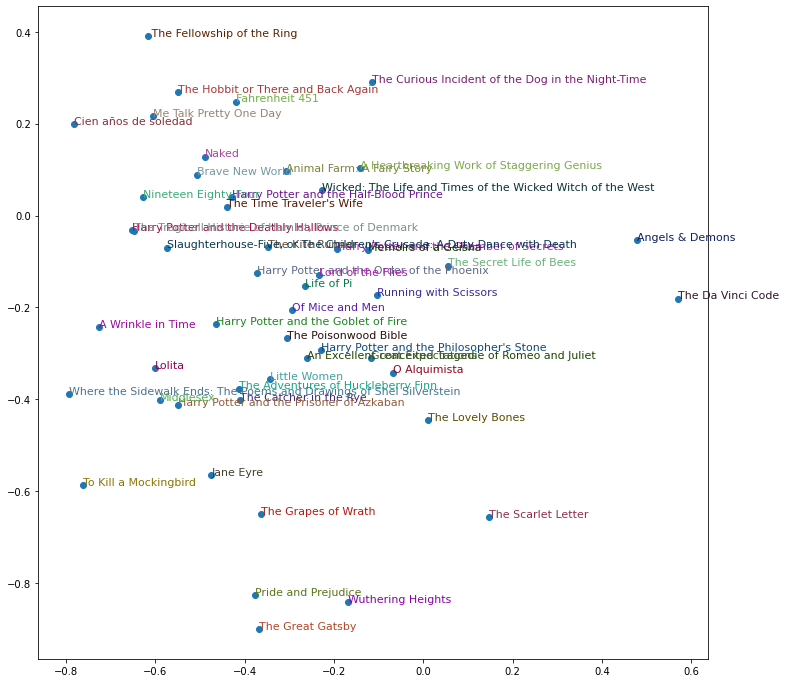

In [28]:
g = ratings.groupby('original_title')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:10000]
top_idxs = tensor([learn.dls.classes['original_title'].o2i[m] for m in top_books])
books_w = learn.model.i_weights.weight[top_idxs].cpu().detach()
books_pca = books_w.pca(3)
fac0,fac1,fac2 = books_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Generating book reviews

In [29]:
book_factors = learn.model.i_weights.weight
idx = dls.classes['original_title'].o2i['Dune']
distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
idx = distances.argsort(descending=True)[1:6]
# dls.classes['original_title'][idx]
[dls.classes['original_title'][i] for i in idx]

['Genius: The Life and Science of Richard Feynman',
 "Surely You're Joking, Mr. Feynman! Adventures of a Curious Character",
 'Far from the Madding Crowd',
 'Terrier',
 'Griffin & Sabine: An Extraordinary Correspondence']

## Neural Network Model

In [30]:
class CollabFilteringNN(Module):

    def __init__(self, user_sz, book_sz, y_range=(0, 5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.book_factors = Embedding(*book_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+book_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1)
        )
        self.y_range = y_range


    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.book_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [33]:
nn_model = CollabFilteringNN(*get_emb_sz(dls)); nn_model

CollabFilteringNN(
  (user_factors): Embedding(1795, 106)
  (book_factors): Embedding(4879, 186)
  (layers): Sequential(
    (0): Linear(in_features=292, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [34]:
learn = Learner(dls, nn_model, loss_func=MSELossFlat())

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.009120108559727669)

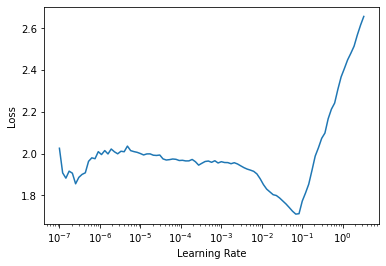

In [35]:
learn.lr_find()

In [36]:
learn = Learner(dls, nn_model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 1e-2, wd=0.05)

epoch,train_loss,valid_loss,time
0,0.871426,0.866779,00:05
1,0.831631,0.814033,00:05
2,0.797109,0.804202,00:05
3,0.770979,0.785494,00:05
4,0.662325,0.796811,00:05


## Using full dataset

In [7]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [13]:
ratings = ratings.merge(books)
ratings.head()

,user_id,book_id,rating,goodreads_book_id,authors,original_publication_year,original_title,average_rating
0,1,258,5,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
1,11,258,3,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
2,143,258,4,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
3,242,258,5,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24
4,325,258,4,1232,"Carlos Ruiz Zafón, Lucia Graves",2001.0,La sombra del viento,4.24


In [14]:
dls = CollabDataLoaders.from_df(ratings=ratings, valid_pct=0.2, 
                                user_name='user_id', item_name='original_title',
                                rating_name='rating')

In [15]:
dls.show_batch()

,user_id,original_title,rating
0,20172,Body of Evidence,3
1,42096,The Pillars of Creation,5
2,6973,Count Zero,4
3,19572,The Scorpio Races,5
4,11190,The Grapes of Wrath,5
5,27969,The Fault in Our Stars,5
6,53283,The Secret History,2
7,48218,Ancillary Sword,3
8,5628,American Psycho,3
9,23404,Thief of Time,5


In [16]:
n_users = len(dls.classes['user_id'])
n_books = len(dls.classes['original_title'])

In [17]:
learn = collab_learner(dls, n_factors=500, y_range=(0, 5.5))

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=3.981071586167673e-06)

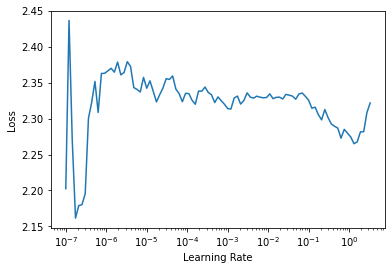

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(4, 1e-1)

epoch,train_loss,valid_loss,time
0,7.149027,7.212011,16:50
1,7.053800,7.056503,17:14
2,5.107837,5.185024,16:39
3,1.094152,1.096410,15:29


In [20]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,time
0,0.630934,0.750140,14:13
1,0.396584,0.716600,14:25


In [21]:
learn.save('collab_filtering_6epochs')

Path('models/collab_filtering_6epochs.pth')

## Interpretation of final model

In [22]:
book_bias = learn.model.i_bias.weight.squeeze()
idxs = book_bias.argsort()[:5]
[dls.classes['original_title'][i] for i in idxs]

['One Night @ The Call Center',
 'The 3 Mistakes of My Life',
 'Half Girlfriend',
 'Revolution 2020: Love, Corruption, Ambition',
 'Four Blondes']

In [23]:
idxs = book_bias.argsort(descending=True)[:5]
[dls.classes['original_title'][i] for i in idxs]

['The Complete Calvin and Hobbes',
 'Words of Radiance',
 'Calvin and Hobbes',
 'Complete Harry Potter Boxed Set',
 'A Court of Mist and Fury']

In [24]:
id = int(books.loc[books['original_title']=='The Complete Calvin and Hobbes']['goodreads_book_id'].values)
url = f'https://www.goodreads.com/book/show/{id}'
url

'https://www.goodreads.com/book/show/24812'

In [25]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(53425, 500)
  (i_weight): Embedding(9269, 500)
  (u_bias): Embedding(53425, 1)
  (i_bias): Embedding(9269, 1)
)

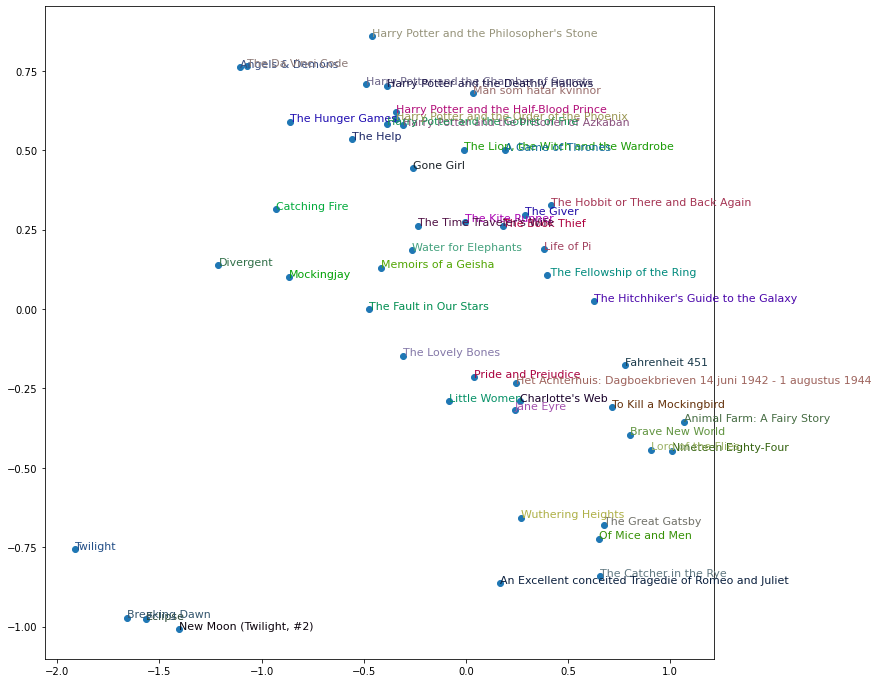

In [26]:
g = ratings.groupby('original_title')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:10000]
top_idxs = tensor([learn.dls.classes['original_title'].o2i[m] for m in top_books])
books_w = learn.model.i_weight.weight[top_idxs].cpu().detach()
books_pca = books_w.pca(3)
fac0,fac1,fac2 = books_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [28]:
book_factors = learn.model.i_weight.weight
idx = dls.classes['original_title'].o2i['The Hitchhiker Guide to the Galaxy']
distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
idx = distances.argsort(descending=True)[1:6]
# dls.classes['original_title'][idx]
[dls.classes['original_title'][i] for i in idx]

['Thoughtless',
 'Crescendo',
 'Eleanor & Park',
 'A Storm of Swords',
 'Fifty Shades of Grey']

In [29]:
learn.export('production_model.pkl')